In [218]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Import & manipulate data

In [219]:
# Use historic data as training set to select important features
# Import the historic data
historic_data = pd.read_csv("../historic_first_pred.csv")
historic_data

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,service_mapping_paeds,service_mapping_priority,service_mapping_surgical,weekswaiting,no_show,did_not_attend_risk,did_not_attend_risk_group,prediction_type,case_control,use_case
0,10079786,52,27.45,NaN,0,1,1,2,0,0,...,0,0,0,NaN,0.0,0.264963,High Risk,First prediction,1.0,3
1,10164094,52,27.45,NaN,1,0,1,2,0,1,...,0,0,0,NaN,1.0,0.266140,High Risk,First prediction,1.0,3
2,10193130,57,21.70,NaN,0,0,1,3,0,1,...,0,0,0,NaN,0.0,0.202084,High Risk,First prediction,1.0,3
3,10211058,32,39.45,NaN,0,1,0,2,0,0,...,0,0,0,NaN,1.0,0.062844,Low Risk,First prediction,1.0,3
4,10550310,72,39.45,NaN,1,0,1,4,0,0,...,0,0,0,NaN,0.0,0.040898,Low Risk,First prediction,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139396,6850436,57,39.45,NaN,0,0,1,4,0,0,...,0,0,0,NaN,0.0,0.236635,High Risk,First prediction,1.0,3
139397,8776815,27,27.45,NaN,1,0,1,2,0,0,...,0,0,0,NaN,0.0,0.561522,Very High Risk,First prediction,1.0,3
139398,9143144,32,27.45,NaN,1,0,1,2,0,0,...,0,0,0,NaN,0.0,0.393163,High Risk,First prediction,1.0,3
139399,9421052,62,39.45,NaN,1,0,0,4,0,0,...,0,0,0,NaN,0.0,0.250568,High Risk,First prediction,1.0,3


In [220]:
# Check for missing values
historic_data.isnull().sum()

appointment_id                               0
age_deid                                     0
bmi_deid                                     0
ethnicity                               139401
ethnic_category_black                        0
ethnic_category_unknown                      0
gender_male                                  0
imd19_quintile                               0
main_spoken_language_other                   0
current_smoker                               0
substance_misuse                             0
smoking_unknown                              0
referral_to_treatment_period_status     139401
tfc_name                                139401
patient_on_multiple_pathways            139401
appt_month                              139401
appt_hour                               139401
appt_duration                           139401
hospital_service_display                139401
service_mapping                         139401
reason_display                          139401
appointment_t

In [221]:
# Drop missing and other irrelevant columns
historic_data = historic_data.dropna(axis=1).drop(columns=["prediction_type", "use_case", "case_control"])
historic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139401 entries, 0 to 139400
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   appointment_id                        139401 non-null  int64  
 1   age_deid                              139401 non-null  int64  
 2   bmi_deid                              139401 non-null  float64
 3   ethnic_category_black                 139401 non-null  int64  
 4   ethnic_category_unknown               139401 non-null  int64  
 5   gender_male                           139401 non-null  int64  
 6   imd19_quintile                        139401 non-null  int64  
 7   main_spoken_language_other            139401 non-null  int64  
 8   current_smoker                        139401 non-null  int64  
 9   substance_misuse                      139401 non-null  int64  
 10  smoking_unknown                       139401 non-null  int64  
 11  

In [222]:
# Encode the did_not_attend_risk_group column
risk_mapping ={
    "Low Risk": 1,
    "Moderate Risk": 2,
    "High Risk": 3,
    "Very High Risk": 4,
}

# Map the month names to numbers
historic_data["did_not_attend_risk_group"] = historic_data["did_not_attend_risk_group"].map(risk_mapping)

historic_data[['did_not_attend_risk_group']]

,did_not_attend_risk_group
0,3
1,3
2,3
3,1
4,1
...,...
139396,3
139397,4
139398,3
139399,3


In [223]:
# Import the transformed use case 1 data (future data) as test set
future_data = pd.read_csv("../useCase1_trans.csv")
future_data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,use_case,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,14943511,32,27.45,0,0,1,2,0,0,0,...,1,0,17,0,10,40,2,176,0,3
1,15742730,42,27.45,0,1,0,1,0,0,0,...,1,3,11,0,8,15,0,72,0,3
2,16778162,22,21.70,0,0,0,2,0,0,0,...,1,5,11,0,5,23,10,105,0,4
3,16994098,32,39.45,0,1,0,2,0,0,0,...,1,3,13,0,6,24,4,110,0,2
4,17047096,62,27.45,0,0,1,1,0,0,0,...,1,3,2,1,5,6,2,29,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15836,20254158,32,21.70,0,0,1,3,0,0,0,...,1,5,16,0,9,39,2,165,0,3
15837,20254160,82,27.45,1,0,0,2,0,0,0,...,1,1,16,0,9,39,2,165,0,1
15838,20254163,82,27.45,1,0,0,1,0,1,0,...,1,1,16,1,9,39,2,165,0,1
15839,20283951,32,27.45,0,1,1,2,0,0,0,...,1,3,34,0,7,43,6,254,0,2


In [224]:
# Check for missing values
future_data.isnull().sum()

appointment_id                              0
age_deid                                    0
bmi_deid                                    0
ethnic_category_black                       0
ethnic_category_unknown                     0
gender_male                                 0
imd19_quintile                              0
main_spoken_language_other                  0
current_smoker                              0
substance_misuse                            0
smoking_unknown                             0
referral_to_treatment_period_status     15841
appt_hour                                   0
appt_duration                               0
new_appt_flag                               0
appointment_type_telephone                  0
appt_hour_11am_to_12pm                      0
appt_hour_12pm_to_1pm                       0
appt_hour_2pm_to_3pm                        0
appt_season_winter                          0
days_last_appt                              0
emergency_enc_last_12m_one_or_two 

In [225]:
# Drop the missing & irrelevant value columns
future_data = future_data.dropna(axis=1).drop(columns=["use_case"])

future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15841 entries, 0 to 15840
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   appointment_id                        15841 non-null  int64  
 1   age_deid                              15841 non-null  int64  
 2   bmi_deid                              15841 non-null  float64
 3   ethnic_category_black                 15841 non-null  int64  
 4   ethnic_category_unknown               15841 non-null  int64  
 5   gender_male                           15841 non-null  int64  
 6   imd19_quintile                        15841 non-null  int64  
 7   main_spoken_language_other            15841 non-null  int64  
 8   current_smoker                        15841 non-null  int64  
 9   substance_misuse                      15841 non-null  int64  
 10  smoking_unknown                       15841 non-null  int64  
 11  appt_hour      

In [226]:
# Remove all the "_trans" suffixes from the column names

# Identify columns with "_trans" suffix in the test set
columns_to_rename = {col: col.replace('_trans', '') for col in future_data.columns if col.endswith('_trans')}

# Rename the columns in the test set
future_data.rename(columns=columns_to_rename, inplace=True)

# List columns in the future_data
future_data.columns


Index(['appointment_id', 'age_deid', 'bmi_deid', 'ethnic_category_black',
       'ethnic_category_unknown', 'gender_male', 'imd19_quintile',
       'main_spoken_language_other', 'current_smoker', 'substance_misuse',
       'smoking_unknown', 'appt_hour', 'appt_duration', 'new_appt_flag',
       'appointment_type_telephone', 'appt_hour_11am_to_12pm',
       'appt_hour_12pm_to_1pm', 'appt_hour_2pm_to_3pm', 'appt_season_winter',
       'days_last_appt', 'emergency_enc_last_12m_one_or_two',
       'emergency_enc_last_12m_three_or_more', 'lead_time', 'ltc_count',
       'ns_rate_seq', 'num_reschedules_one', 'num_reschedules_two_or_more',
       'op_appts_last_12m', 'osrm_drive_time', 'other_vulnerability',
       'past_no_show_count_one', 'past_no_show_count_three_or_more',
       'past_no_show_count_two', 'past_no_show_rate', 'phone_number',
       'physically_inactive', 'safeguarding',
       'service_mapping_allied_hcp_therapy', 'service_mapping_paeds',
       'service_mapping_priority',

In [155]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# future_data["did_not_attend_risk_group"] = future_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == 4 else 0)

# # Check the transformation has been properly applied
# future_data["did_not_attend_risk_group"].unique()

array([0, 1])

### Exploratory analysis: compare means (historic data)

In [203]:
historic_data.info()
# Continuous variables: age_deid, bmi_deid, lead_time, ltc_count, ns_rate_seq, op_appts_last_12m, osrm_drive_time, did_not_attend_risk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139401 entries, 0 to 139400
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   appointment_id                        139401 non-null  int64  
 1   age_deid                              139401 non-null  int64  
 2   bmi_deid                              139401 non-null  float64
 3   ethnic_category_black                 139401 non-null  int64  
 4   ethnic_category_unknown               139401 non-null  int64  
 5   gender_male                           139401 non-null  int64  
 6   imd19_quintile                        139401 non-null  int64  
 7   main_spoken_language_other            139401 non-null  int64  
 8   current_smoker                        139401 non-null  int64  
 9   substance_misuse                      139401 non-null  int64  
 10  smoking_unknown                       139401 non-null  int64  
 11  

In [212]:
# Create the an exploratory df by extracting the continuous variables and the target variable
continuous_vars = ["age_deid", "bmi_deid", "lead_time", "ltc_count", "ns_rate_seq", "op_appts_last_12m", "osrm_drive_time", "did_not_attend_risk"]
exploratory_data = historic_data[continuous_vars + [ "did_not_attend_risk_group"]]
exploratory_data

,age_deid,bmi_deid,lead_time,ltc_count,ns_rate_seq,op_appts_last_12m,osrm_drive_time,did_not_attend_risk,did_not_attend_risk_group
0,52,27.45,36,0,0.29,0,16.69,0.264963,3
1,52,27.45,258,2,0.17,0,5.16,0.266140,3
2,57,21.70,14,2,0.29,0,9.87,0.202084,3
3,32,39.45,11,0,0.07,0,4.91,0.062844,1
4,72,39.45,11,2,0.07,0,8.35,0.040898,1
...,...,...,...,...,...,...,...,...,...
139396,57,39.45,325,2,0.10,0,7.63,0.236635,3
139397,27,27.45,317,2,0.29,0,7.00,0.561522,4
139398,32,27.45,37,2,0.34,1,6.08,0.393163,3
139399,62,39.45,205,10,0.05,3,7.92,0.250568,3


In [217]:
# Perform independent two-sample t-test for the exploratory data

# Initialise a list to sore results
results = []

# Loop through the continuous variables
for var in continuous_vars:
    # Split out the 2 risk groups
    risk_veryHigh = exploratory_data[exploratory_data["did_not_attend_risk_group"] == 4]
    risk_lower = exploratory_data[exploratory_data["did_not_attend_risk_group"] != 4]

    # Calculate the t-statistic and p-value
    t_stat, p_value = ttest_ind(risk_veryHigh[var], risk_lower[var])

    # Calculate the mean
    mean_veryHigh = risk_veryHigh.mean()
    mean_lower = risk_lower.mean()

    # Store the results
    results.append({
        "Variables": var,
        "Mean very high risk": mean_veryHigh[var],
        "Mean lower risk": mean_lower[var],
        "t-statistic": t_stat,
        "p-value": p_value
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df



,Variables,Mean very high risk,Mean lower risk,t-statistic,p-value
0,age_deid,37.234909,45.693674,-14.800151,1.593976e-49
1,bmi_deid,28.803600,28.872996,-0.372280,7.096848e-01
2,lead_time,127.220364,57.649805,34.811480,2.246134e-264
3,ltc_count,1.531636,1.504499,0.537133,5.911765e-01
4,ns_rate_seq,0.376182,0.082663,197.873614,0.000000e+00
5,op_appts_last_12m,3.314909,5.707859,-11.301004,1.336353e-29
6,osrm_drive_time,7.736109,7.457195,3.305836,9.471728e-04
7,did_not_attend_risk,0.540632,0.110317,247.318611,0.000000e+00


### Select subset of important features using GenericUnivariateSelect

#### V1: outcome = did not attend risk; drop: no show (historic)

In [227]:
# Define training and test sets
X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
y_train = historic_data["did_not_attend_risk_group"]

X_test = future_data.drop("did_not_attend_risk_group", axis=1)
y_test = future_data["did_not_attend_risk_group"]

#### V2: outcome = no show; drop: did not attend risk (historic) 
##### --> no distinctive differences shown on t-SNE

In [157]:
# # Define training and test sets
# X_train = historic_data.drop(["did_not_attend_risk_group", "no_show"], axis=1)
# y_train = historic_data["no_show"]

# X_test = future_data.drop("did_not_attend_risk_group", axis=1)
# y_test = future_data["did_not_attend_risk_group"]

In [228]:
# Identify missing features - fix with new data
missing_in_train = set(X_test.columns) - set(X_train.columns)
missing_in_test = set(X_train.columns) - set(X_test.columns)

print("Features in test set but not in training set:", missing_in_train)
print("Features in training set but not in test set:", missing_in_test)

Features in test set but not in training set: {'reason_display', 'hospital_service_display', 'appt_hour', 'weekswaiting', 'appt_month', 'appointment_type', 'tfc_name', 'patient_on_multiple_pathways', 'appt_duration', 'ethnicity', 'service_mapping'}
Features in training set but not in test set: set()


In [229]:
# Align feature columns
# Add missing columns to training set with default values (e.g., 0)
for col in missing_in_train:
    X_train[col] = 0

# Add missing columns to test set with default values (e.g., 0)
for col in missing_in_test:
    X_test[col] = 0

# Reorder the columns to match
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_test.columns)]


In [230]:
# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [231]:
# Fit GenericUnivariateSelect with mutual information for feature selection
selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=20) # Select top 20% of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train) # Fit the selector to the training data

# Identify selected features
selected_features = selector.get_support(indices=True) # Returns an array of indices of selected features
selected_features_names = X_train.columns[selected_features] # Get the names of selected features
selected_features_names

Index(['age_deid', 'appointment_id', 'days_last_appt', 'did_not_attend_risk',
       'lead_time', 'new_appt_flag', 'ns_rate_seq', 'osrm_drive_time',
       'past_no_show_count_three_or_more', 'past_no_show_rate'],
      dtype='object')

### Fit & plot t-SNE

In [162]:
# Transform the test set for consistency & reduce dimensionality
X_test_selected = selector.transform(X_test_scaled)

In [163]:
# # Transform risk categories so that 1 = very high risk and 0 = the rest (high, moderate, low)
# historic_data["did_not_attend_risk_group"] = historic_data["did_not_attend_risk_group"].apply(lambda x: 1 if x == "Very High Risk" else 0)

# # Check the transformation has been properly applied
# historic_data["did_not_attend_risk_group"].unique()

In [164]:
# Apply t-SNE on the selected features of the test set
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_selected) # Fit and transform the data

In [165]:
# Create a DataFrame with the t-SNE data
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["did_not_attend_risk_group"] = y_test.reset_index(drop=True) # Add the target variable

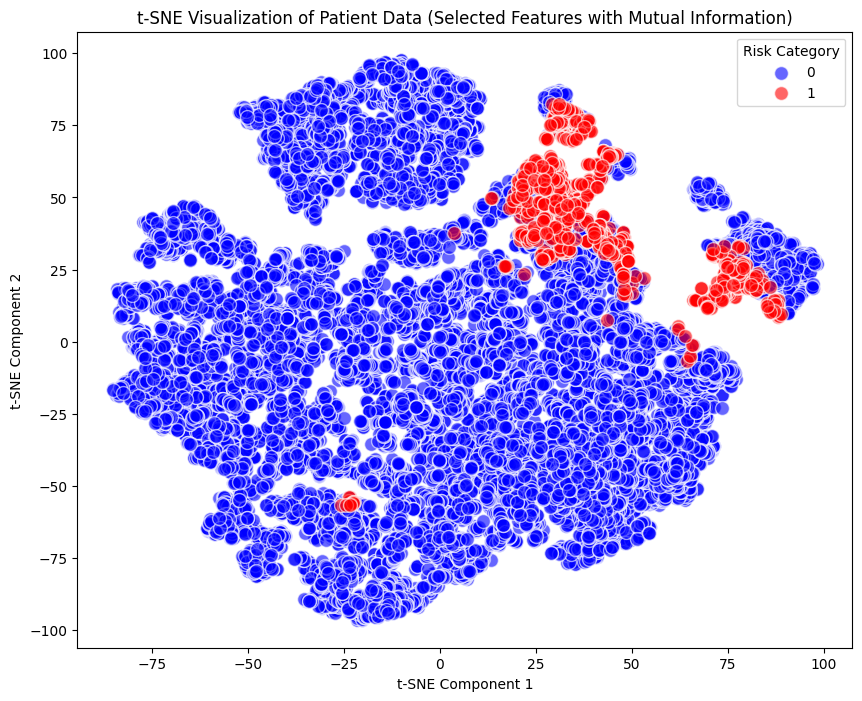

In [166]:
# # Plot the t-SNE (for 2 risk categories: very high risk vs the rest)
# colours = {0: "blue", 1: "red"}

# plt.figure(figsize=(10, 8))
# for category in tsne_df['did_not_attend_risk_group'].unique():
#     subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
#     plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, color=colours[category], alpha=0.6, edgecolors='w', s=100)

# # Add title and labels
# plt.title('t-SNE Visualization of Patient Data (Selected Features with Mutual Information)')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')

# # Add legend
# plt.legend(title='Risk Category')

# # Show plot
# plt.show()

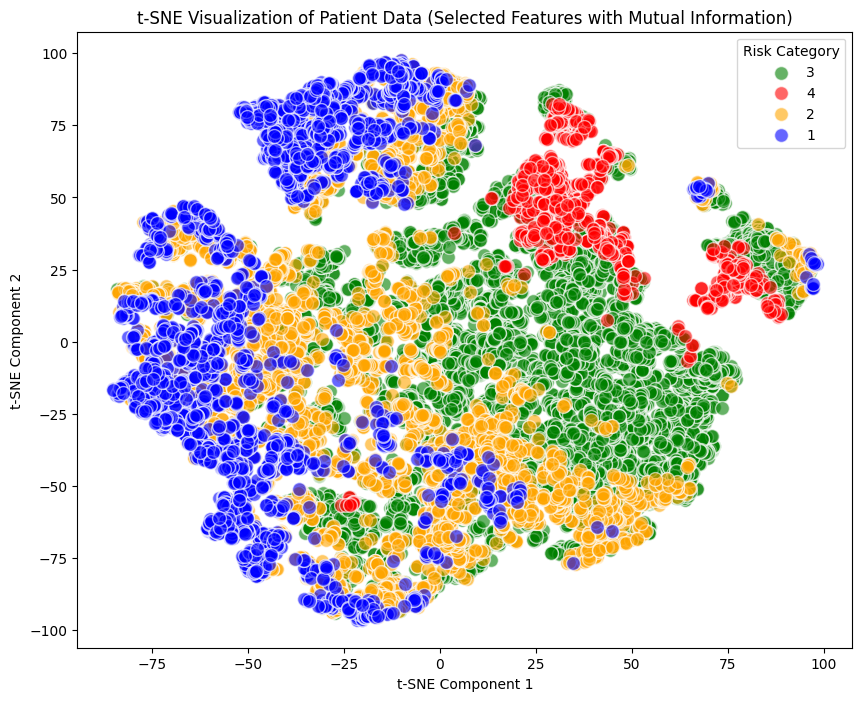

In [43]:
# Plot the t-SNE (for 4 risk categories)
colours = {
    1: "blue",
    2: "orange",
    3: "green",
    4: "red"
}

plt.figure(figsize=(10, 8))
for category in tsne_df['did_not_attend_risk_group'].unique():
    subset = tsne_df[tsne_df['did_not_attend_risk_group'] == category]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=category, color=colours[category], alpha=0.6, edgecolors='w', s=100)

# Add title and labels
plt.title('t-SNE Visualization of Patient Data (Selected Features with Mutual Information)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend
plt.legend(title='Risk Category')

# Show plot
plt.show()

# Draw out the differences by comparing the selected features

In [232]:
# Create a dataframe with the selected features
selected_data = future_data[selected_features_names]

# Add the risk group column
selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True) 

/var/folders/0t/dc47jt692_qc1qb7bqkgylhw0000gn/T/ipykernel_6691/3671777271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["did_not_attend_risk_group"] = y_test.reset_index(drop=True)


In [233]:
# Group by risk category and summarise: continuous variables
grouped_data_cont = selected_data.drop(["new_appt_flag", "past_no_show_count_three_or_more"], axis=1).groupby("did_not_attend_risk_group").agg(["mean", "std"])
grouped_data_cont

age_deid            appointment_id                 \
                                mean        std           mean            std   
did_not_attend_risk_group                                                       
1                          53.734959  23.661288   1.984145e+07  353479.349544   
2                          47.209928  23.007781   1.956261e+07  540054.413818   
3                          41.541075  20.116666   1.939181e+07  619382.261367   
4                          38.622951  16.927097   1.938270e+07  623369.365116   

                          days_last_appt             did_not_attend_risk  \
                                    mean         std                mean   
did_not_attend_risk_group                                                  
1                             351.949593  503.698679            0.083237   
2                             308.612326  445.603508            0.144271   
3                             238.717849  376.618269            0.262172   
4                             312.505304  393.127576            0.551184   

                                      lead_time            ns_rate_seq  \
                                std        mean        std        mean   
did_not_attend_risk_group                                                
1                          0.018208  107.661463  65.706477    0.063415   
2                          0.020266  199.763568  96.621705    0.075088   
3                          0.062420  280.189247  86.077952    0.108548   
4                          0.102498  287.460945  84.839888    0.292719   

                                    osrm_drive_time            \
                                std            mean       std   
did_not_attend_risk_group                                       
1                          0.019803        7.622263  3.382401   
2                          0.030666        7.935385  3.790327   
3                          0.061239        8.323356  3.979160   
4                          0.111120        8.810338  4.767927   

                          past_no_show_rate            
                                       mean       std  
did_not_attend_risk_group                              
1                                  0.026709  0.060949  
2                                  0.049661  0.094612  
3                                  0.131662  0.195778  
4                                  0.575121  0.306332

In [234]:
# Group by risk category and summarise: categorical variables
print(selected_data[["new_appt_flag"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())
print()
print(selected_data[["past_no_show_count_three_or_more"]].groupby(selected_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

new_appt_flag                     0         1
did_not_attend_risk_group                    
1                          0.367805  0.632195
2                          0.159234  0.840766
3                          0.057778  0.942222
4                          0.018322  0.981678

past_no_show_count_three_or_more         0         1
did_not_attend_risk_group                           
1                                 0.988618  0.011382
2                                 0.975599  0.024401
3                                 0.926165  0.073835
4                                 0.751205  0.248795


#### Adding in features selected by the client

In [238]:
# Ethnicity: black
print(historic_data[["ethnic_category_black"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

ethnic_category_black             0         1
did_not_attend_risk_group                    
1                          0.796189  0.203811
2                          0.686502  0.313498
3                          0.667958  0.332042
4                          0.682182  0.317818

other_vulnerability               0         1
did_not_attend_risk_group                    
1                          0.988015  0.011985
2                          0.974756  0.025244
3                          0.940149  0.059851
4                          0.886545  0.113455


In [239]:
# Other vulnerability
print(historic_data[["other_vulnerability"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

other_vulnerability               0         1
did_not_attend_risk_group                    
1                          0.988015  0.011985
2                          0.974756  0.025244
3                          0.940149  0.059851
4                          0.886545  0.113455


In [245]:
# IMD 19 quitile
print(historic_data[["imd19_quintile"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

imd19_quintile                    1         2         3         4         5
did_not_attend_risk_group                                                  
1                          0.226575  0.433585  0.243254  0.090558  0.006027
2                          0.296988  0.456513  0.188460  0.053701  0.004339
3                          0.328843  0.455250  0.172172  0.040844  0.002891
4                          0.328727  0.453091  0.177455  0.037091  0.003636


In [246]:
# Safeguarding
print(historic_data[["safeguarding"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

safeguarding                      0         1
did_not_attend_risk_group                    
1                          0.959630  0.040370
2                          0.913504  0.086496
3                          0.872855  0.127145
4                          0.802182  0.197818


In [248]:
# Substance misuse
print(historic_data[["substance_misuse"]].groupby(historic_data["did_not_attend_risk_group"]).value_counts(normalize=True).unstack())

substance_misuse                  0         1
did_not_attend_risk_group                    
1                          0.992130  0.007870
2                          0.974812  0.025188
3                          0.935228  0.064772
4                          0.847273  0.152727
